In [1]:
from data_processing import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import numpy as np
from noise import NoiseScheduler
import torch
from jet_finding import *

testEvent=0


In [2]:
baseDir='/hdfs/user/ys20884/hackathon/data'
dataset = Dataset(1_000, (120, 72), signal_file=f"{baseDir}/CaloImages_signal.root", pile_up_file=f"{baseDir}/CaloImages_bkg.root", save=False)

In [3]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
100%|██████████| 1000/1000 [00:01<00:00, 695.20it/s]
INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
100%|██████████| 1000/1000 [00:01<00:00, 690.41it/s]


In [4]:
new_dim=(64,64)

dataset.preprocess(16, new_dim)

INFO:root:scaling
scaling
INFO:root:re-sizing
re-sizing


In [5]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [6]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)

In [7]:
noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([40]) #each unit of timestep represents an addtional 5 pile-up events
random_seed = 42
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[testEvent], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)


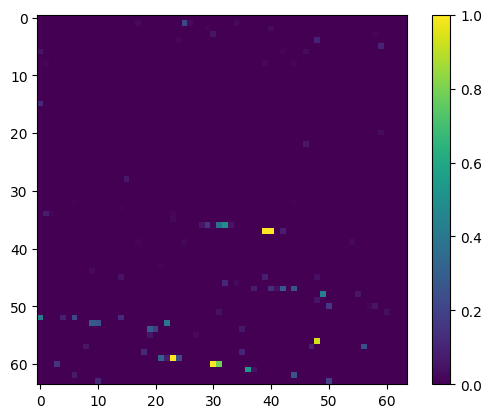

In [8]:
plt.imshow(clean_frames[testEvent].reshape(new_dim))
plt.colorbar()


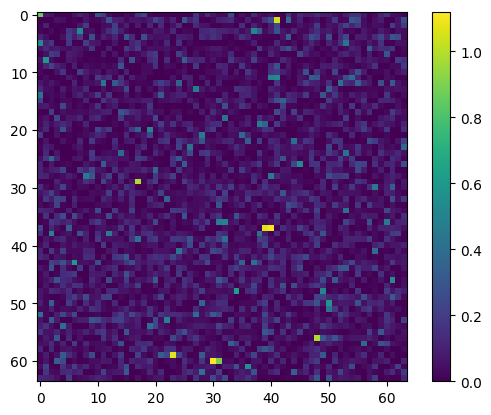

In [9]:
plt.imshow(noisy_image.reshape(new_dim))
plt.colorbar()


In [10]:
from models import Model

model = Model('UNet-lite', new_dim)

In [11]:
model = model.__getitem__()

In [89]:
trained_model_path = '/hdfs/user/ys20884/hackathon/trained_models/trained_diffusor.pt'
# trained_model_path = 'trained_models_lite/model_epoch_9.pt'

In [90]:
checkpoint = torch.load(trained_model_path)

In [91]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [92]:
noise_pred = model(noisy_image.unsqueeze(1), timestep)[testEvent]

In [93]:
de_noised = noisy_image[testEvent] - (noise_pred.detach().numpy().reshape(new_dim))

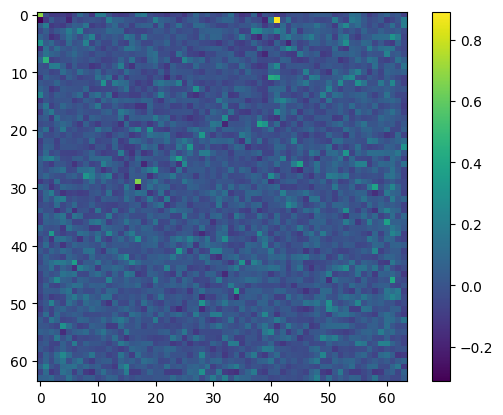

In [94]:
plt.imshow(de_noised.reshape(new_dim))
plt.colorbar()

In [95]:
clean_frames[testEvent].reshape(new_dim)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [96]:
local_maxima, jets_clean = find_local_maxima( clean_frames[testEvent].reshape(new_dim), 9 )

In [97]:
print (local_maxima)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


9


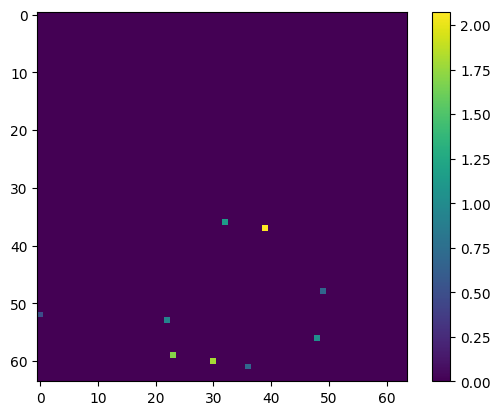

In [98]:
plt.imshow(local_maxima)
print (len(jets_clean))
plt.colorbar()

48


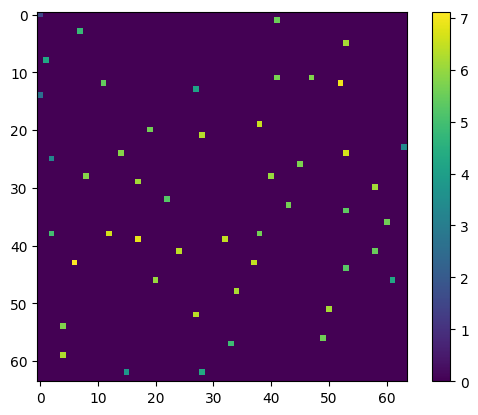

In [99]:
local_maxima, jets_noisy = find_local_maxima( noisy_image.reshape(new_dim), 9 )
print (len(jets_noisy))
plt.imshow(local_maxima)
plt.colorbar()

In [100]:
local_maxima, jets_denoised = find_local_maxima( de_noised.reshape(new_dim), 9 )


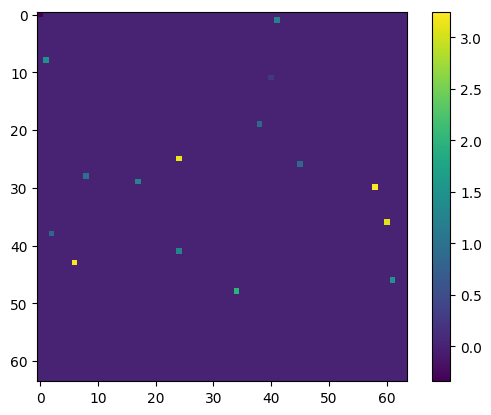

In [101]:
plt.imshow(local_maxima)
plt.colorbar()

In [106]:
print (jets_denoised)

[{'i': 0, 'j': 0, 'pixel_value': tensor(0.6876), 'sum_around_maxima': -0.3385725}, {'i': 1, 'j': 41, 'pixel_value': tensor(0.8908), 'sum_around_maxima': 1.2303034}, {'i': 8, 'j': 1, 'pixel_value': tensor(0.4674), 'sum_around_maxima': 1.4802359}, {'i': 11, 'j': 40, 'pixel_value': tensor(0.4379), 'sum_around_maxima': 0.2494214}, {'i': 19, 'j': 38, 'pixel_value': tensor(0.3941), 'sum_around_maxima': 0.8798665}, {'i': 25, 'j': 24, 'pixel_value': tensor(0.3871), 'sum_around_maxima': 3.1651194}, {'i': 26, 'j': 45, 'pixel_value': tensor(0.3864), 'sum_around_maxima': 0.8681506}, {'i': 28, 'j': 8, 'pixel_value': tensor(0.3146), 'sum_around_maxima': 0.99007314}, {'i': 29, 'j': 17, 'pixel_value': tensor(0.6608), 'sum_around_maxima': 1.2551118}, {'i': 30, 'j': 58, 'pixel_value': tensor(0.3843), 'sum_around_maxima': 3.2507124}, {'i': 36, 'j': 60, 'pixel_value': tensor(0.3694), 'sum_around_maxima': 3.0954278}, {'i': 38, 'j': 2, 'pixel_value': tensor(0.3315), 'sum_around_maxima': 0.8672265}, {'i': 41

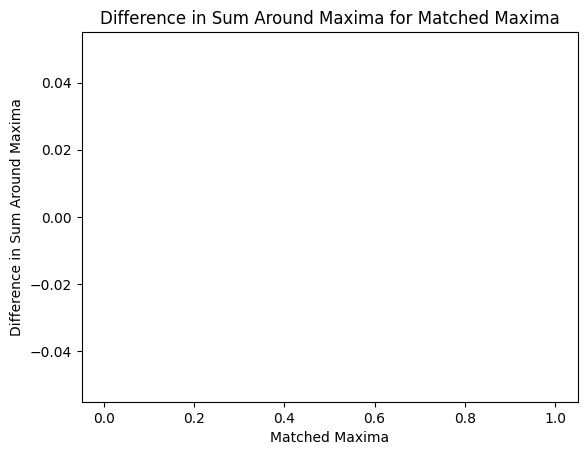

In [103]:
differences_allJetTypes = []
for test_jets in [ jets_noisy, jets_denoised ]:
    matching_jets = find_matching_maxima(jets_clean,test_jets)
    for ref_maxima, test_maxima_entry in matching_jets:
        print(f"Reference Maxima: {ref_maxima}, Test Maxima: {test_maxima_entry}")

    differences = [ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                for ref_maxima, test_maxima_entry in matching_jets]
    differences_allJetTypes.append( differences )

    plt.hist(differences)

plt.xlabel('Matched Maxima')
plt.ylabel('Difference in Sum Around Maxima')
plt.title('Difference in Sum Around Maxima for Matched Maxima')
plt.show()
# # Example usage:
# # Assuming reference_maxima and test_maxima are your lists of maxima positions
# reference_maxima = [...]  # Your list of maxima from the reference
# test_maxima = [...]       # Your list of maxima from the test

# # Find matching maxima
# matching_maxima = find_matching_maxima(reference_maxima, test_maxima)

# # Display the matching maxima
# print("Matching Maxima:")
# for ref_maxima, test_maxima_entry in matching_maxima:
#     print(f"Reference Maxima: {ref_maxima}, Test Maxima: {test_maxima_entry}")

In [104]:
differences_allJetTypes = []

differences_jets_noisy = []
differences_jets_denoised = []
differences_jets_denoised_partial = []

for event in range(100):
    print ("Event : ",event)
    noise_scheduler = NoiseScheduler('pile-up')
    timestep = torch.LongTensor([40]) #each unit of timestep represents an addtional 5 pile-up events
    random_seed = 42

    noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)
    noise_pred = model(noisy_image.unsqueeze(1), timestep)[0]
    de_noised = noisy_image[0] - (noise_pred.detach().numpy().reshape(new_dim))

    noisy_image_partial, noise_partial = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)
    noise_pred_partial = model(noisy_image_partial.unsqueeze(1), torch.LongTensor([1]))[0]
    de_noised_partial = noisy_image_partial[0] - (noise_pred_partial.detach().numpy().reshape(new_dim))


    local_maxima, jets_clean = find_local_maxima( clean_frames[event].reshape(new_dim), 9 )
    local_maxima, jets_noisy = find_local_maxima( noisy_image.reshape(new_dim), 9 )
    local_maxima, jets_denoised = find_local_maxima( de_noised.reshape(new_dim), 9 )
    local_maxima, jets_denoised_partial = find_local_maxima( de_noised_partial.reshape(new_dim), 9 )
    
    matching_jets_noisy = find_matching_maxima(jets_clean,jets_noisy)
    matching_jets_denoised = find_matching_maxima(jets_clean,jets_denoised)
    matching_jets_denoised_partial = find_matching_maxima(jets_clean,jets_denoised_partial)

    differences_jets_noisy.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                    for ref_maxima, test_maxima_entry in matching_jets_noisy])
    differences_jets_denoised.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                    for ref_maxima, test_maxima_entry in matching_jets_denoised])
    differences_jets_denoised_partial.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                    for ref_maxima, test_maxima_entry in matching_jets_denoised_partial])

Event :  0
Event :  1
Event :  2
Event :  3
Event :  4
Event :  5
Event :  6
Event :  7
Event :  8
Event :  9
Event :  10
Event :  11
Event :  12
Event :  13
Event :  14
Event :  15
Event :  16
Event :  17
Event :  18
Event :  19
Event :  20
Event :  21
Event :  22
Event :  23
Event :  24
Event :  25
Event :  26
Event :  27
Event :  28
Event :  29
Event :  30
Event :  31
Event :  32
Event :  33
Event :  34
Event :  35
Event :  36
Event :  37
Event :  38
Event :  39
Event :  40
Event :  41
Event :  42
Event :  43
Event :  44
Event :  45
Event :  46
Event :  47
Event :  48
Event :  49
Event :  50
Event :  51
Event :  52
Event :  53
Event :  54
Event :  55
Event :  56
Event :  57
Event :  58
Event :  59
Event :  60
Event :  61
Event :  62
Event :  63
Event :  64
Event :  65
Event :  66
Event :  67
Event :  68
Event :  69
Event :  70
Event :  71
Event :  72
Event :  73
Event :  74
Event :  75
Event :  76
Event :  77
Event :  78
Event :  79
Event :  80
Event :  81
Event :  82
Event :  83
Ev

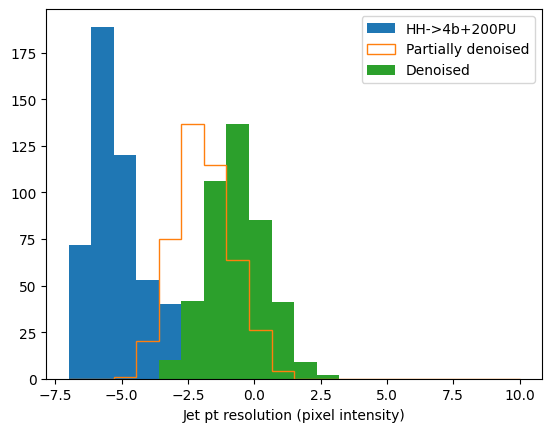

In [105]:
plt.hist(differences_jets_noisy, bins=20, range=(-7,10), label='HH->4b+200PU')#, histtype='step')
plt.hist(differences_jets_denoised_partial, bins=20, range=(-7,10), label='Partially denoised', histtype='step')
plt.hist(differences_jets_denoised, bins=20, range=(-7,10), label='Denoised')#, histtype='step')
plt.xlabel('Jet pt resolution (pixel intensity)')
plt.legend()


In [71]:
print (differences_jets_denoised)

[4.9406776, 4.6338677, 3.9592624, 2.1333973, 1.9040978, 5.461075, 6.7790985, 0.88578594, 3.7161674, 2.6392121, 5.1034203, 4.421358, 5.7094374, 4.05827, 3.7984908, 4.6000977, 3.206287, 6.7441792, 5.8689666, 5.8011, 4.356415, 7.6990337, 5.013765, 4.233664, 6.144384, 5.4687333, 5.387842, 4.6461143, 3.9226031, 4.6276617, 5.2872195, 5.4858046, 5.511796, 3.003981, 5.4551, 5.929773, 3.9327374, 4.3455753, 4.7056317, 4.3166943, 3.8582082, 5.3941984, 5.028061, 4.8413305, 4.178258, 4.75077, 3.7316155, 5.316127, 5.473067, 3.3739874, 3.290597, 1.9439011, 4.1523743, 5.1215525, 5.9307547, 5.2104335, 5.66491, 4.841367, 4.0507298, 5.367585, 5.3750677, 5.822597, 3.1826673, 5.563202, 4.547775, 4.823864, 4.6782293, 4.1904116, 3.3723087, 5.358491, 5.533869, 4.4849625, 4.7231135, 5.543695, 5.9318, 4.9348435, 3.8701146, 1.538307, 1.8837749, 4.683034, 5.548446, 5.2810254, 5.8608723, 5.4721184, 4.8514156, 5.0836873, 5.242296, 4.892289, 5.5512424, 6.166063, 3.5763574, 3.473524, 3.292368, 4.748502, 6.1604986, 5.